In [4]:
import pandas as pd
import numpy as np
from typing import List, Tuple
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import RegressorMixin
import pickle

LEAR_DATA_FILE = 'learn_data.csv'
MODEL_STATE_PATH = 'model.pkl'

FEATURE = ['size', 'ed_count']
Y = 'bug_count'

name_mapping = {
    'size': 'Размер кода (строк) ',
    'ed_count': 'Изменений в коде (раз)',
    'bug_count': 'Найдено багов (шт)',
    f'{Y}_pred': 'Предсказание',
}

def with_read_cols(data: pd.DataFrame):
    data = data.copy().rename(columns=name_mapping)

    return data

# Build learn data

вариант №2

In [ ]:
data = [
    {'index': 0, 'size': 500, 'ed_count': 2, 'bug_count': 3},
    {'index': 1, 'size': 1500, 'ed_count': 5, 'bug_count': 10},
    {'index': 2, 'size': 700, 'ed_count': 1, 'bug_count': 2},
    {'index': 3, 'size': 2000, 'ed_count': 6, 'bug_count': 12},
    {'index': 4, 'size': 1000, 'ed_count': 3, 'bug_count': 5},
]

df = pd.DataFrame.from_records(data)
df.set_index('index')
df.to_csv(LEAR_DATA_FILE, index=False)
with_read_cols(df)

,index,Размер кода (строк),Изменений в коде (раз),Найдено багов (шт)
0,0,500,2,3
1,1,1500,5,10
2,2,700,1,2
3,3,2000,6,12
4,4,1000,3,5


## Load learn data

In [5]:
learn_df = pd.read_csv(LEAR_DATA_FILE)
learn_df.set_index('index')
with_read_cols(learn_df)

,index,Размер кода (строк),Изменений в коде (раз),Найдено багов (шт)
0,0,500,2,3
1,1,1500,5,10
2,2,700,1,2
3,3,2000,6,12
4,4,1000,3,5


## Visualize data dep

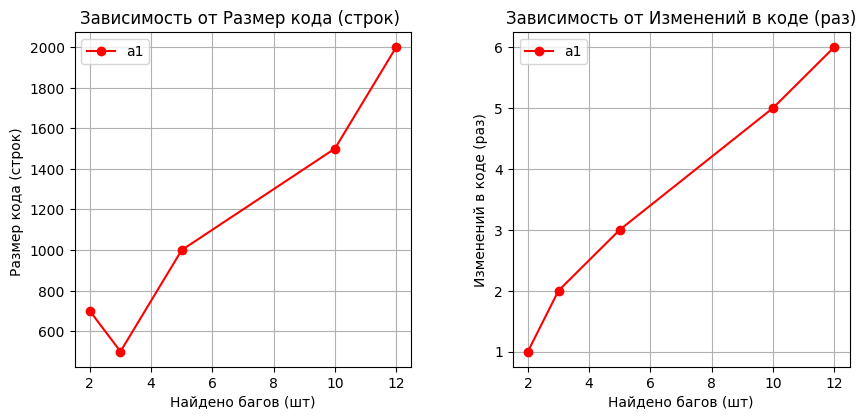

In [7]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots_adjust

def get_values_xy_for(feature: str) -> List[Tuple[int, int]]:
    result = []
    # print(learn_df.sort_values(feature, axis=0)[feature])
    for _, row in learn_df.sort_values(Y, axis=0).iterrows():
        x = row[feature]
        y = row[Y]

        result.append((x, y))

    return result

fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(10)
subplots_adjust(hspace=0.3, wspace=0.3)


for index, feature in enumerate(FEATURE):
    data = get_values_xy_for(feature=feature)
    yy = list(map(lambda x: x[0], data))
    xx = list(map(lambda x: x[1], data))

    ax = fig.add_subplot(2, 2, index + 1)
    ax.plot(xx, yy, color='red', label=f'a1', linestyle='solid', marker='o')
    ax.set_title(f'Зависимость от {name_mapping[feature]}')
    ax.set_ylabel(name_mapping[feature])
    ax.set_xlabel(name_mapping[Y])
    ax.grid()
    ax.legend()

plt.show()



## Learn regr boost ans model

In [9]:
from sklearn.metrics import mean_squared_error

test_df = learn_df.copy()

X = learn_df[FEATURE]
y = learn_df[Y]

model = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=500,
    criterion='friedman_mse',
    max_depth=5,
    min_samples_split=5,
)

model.fit(X, y)

print(f"Model score: {model.score(X, y)}")

model_predict = model.predict(test_df[FEATURE])
print(f"Mean square error: {mean_squared_error(test_df[Y], model_predict)}")

with open(MODEL_STATE_PATH,'wb') as file:
    pickle.dump(model, file)

Model score: 0.9985045454932765
Mean square error: 0.023089817583810096


## Learn linear model

In [10]:
from sklearn.metrics import mean_squared_error

test_df = learn_df.copy()

X = learn_df[FEATURE]
y = learn_df[Y]

model = LinearRegression(
    copy_X=True,
)

model.fit(X, y)

print(f"Model score: {model.score(X, y)}")
print(f"Model coef: {model.coef_}")
print(f"Model base: {model.intercept_}")

model_predict = model.predict(test_df[FEATURE])
print(f"Mean square error: {mean_squared_error(test_df[Y], model_predict)}")

with open(MODEL_STATE_PATH,'wb') as file:
    pickle.dump(model, file)

Model score: 0.9938591441182115
Model coef: [0.00195062 1.55802469]
Model base: -1.1209876543209853
Mean square error: 0.09481481481481474


## Test model

,index,Размер кода (строк),Изменений в коде (раз),Найдено багов (шт),Предсказание
0,0,500,2,3,2.970370
1,1,1500,5,10,9.595062
2,2,700,1,2,1.802469
3,3,2000,6,12,12.128395
4,4,1000,3,5,5.503704


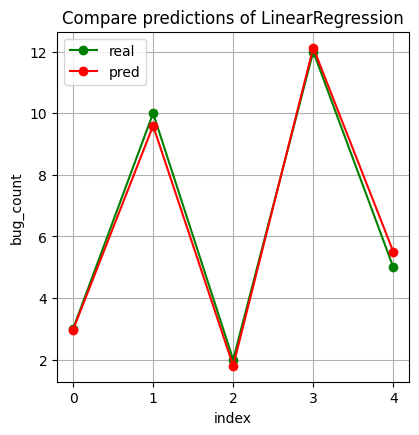

In [11]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots_adjust

Model = LinearRegression

work_df = learn_df.copy()

with open(MODEL_STATE_PATH, 'rb') as f:
    model: Model = pickle.load(f)


predictions = model.predict(work_df[FEATURE])

show_df = work_df.copy()
show_df[f"{Y}_pred"] = predictions

fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(10)

x = list(show_df.index)
y1 = show_df[Y]
y2 = show_df[f"{Y}_pred"]

ax = fig.add_subplot(2, 2, 1)
ax.plot(x, y1, color='green', label=f'real', marker='o', linestyle='-')
ax.plot(x, y2, color='red', label=f'pred', marker='o', linestyle='-')

ax.set_title(f'Compare predictions of {Model.__name__}')
ax.set_xlabel('index')
ax.set_ylabel(f'{Y}')
ax.grid()
ax.legend()
with_read_cols(show_df)
